### Bayesian Semantic Segmentation


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
import tensorflow as tf
import tensorflow.contrib.slim as slim
from utils import unpool_with_argmax
%matplotlib inline

In [2]:
train_file = 'CamVid/train.txt'
val_file = 'CamVid/val.txt'
test_file = 'CamVid/test.txt'

In [3]:
IMAGE_HEIGHT = 72
IMAGE_WIDTH = 96
IMAGE_DEPTH = 3
NUM_CLASSES = 12
TRAIN_BATCH_SIZE=32
VAL_BATCH_SIZE=TRAIN_BATCH_SIZE
TEST_BATCH_SIZE = 1
NUM_ITERS = 2000
NUM_TRAIN = 367

In [4]:
def get_label_colors():
    Sky = [128,128,128]
    Building = [128,0,0]
    Pole = [192,192,128]
    Road_marking = [255,69,0]
    Road = [128,64,128]
    Pavement = [60,40,222]
    Tree = [128,128,0]
    SignSymbol = [192,128,128]
    Fence = [64,64,128]
    Car = [64,0,128]
    Pedestrian = [64,64,0]
    Bicyclist = [0,128,192]
    Unlabelled = [0,0,0]

    label_colors = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, 
                             Fence, Car, Pedestrian, Bicyclist, Unlabelled])
    return label_colors

def img_annot_to_rgb(img_annot):
    r = img_annot.copy()
    g = img_annot.copy()
    b = img_annot.copy()
    label_colors = get_label_colors()
    for i in range(len(label_colors)):
        r[img_annot==i]=label_colors[i,0]
        g[img_annot==i]=label_colors[i,1]
        b[img_annot==i]=label_colors[i,2]
    return np.stack([r,g,b],axis=2)/255.0

def visualize_image_annot(img_data, annot_data, predicted_annot=None):
    if predicted_annot is None:
        fig, ax = plt.subplots(1,2,figsize=(10,12))
        ax[0].imshow(img_data)
        ax[0].set_title('Original Image')
        ax[1].imshow(img_annot_to_rgb(annot_data))
        ax[1].set_title('True Segmentation')
        plt.show()
    else:
        fig, ax = plt.subplots(1,3,figsize=(10,12))
        ax[0].imshow(img_data)
        ax[0].set_title('Original Image')
        ax[1].imshow(img_annot_to_rgb(predicted_annot))
        ax[1].set_title('Predicted Segmentation')
        ax[2].imshow(img_annot_to_rgb(annot_data))
        ax[2].set_title('True Segmentation')
        plt.show()

In [5]:
def load_data(file, train=True, batch_size=10, labels=True):
    def _load_image(filename):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        return image_decoded

    def _load_image_with_labels(filenames):
        image_string = tf.read_file(filenames[0])
        image_decoded = tf.image.decode_png(image_string, channels=3)
        image_decoded = tf.image.convert_image_dtype(image_decoded,tf.float32)
        image_decoded = tf.image.resize_images(image_decoded, [IMAGE_HEIGHT, IMAGE_WIDTH])
        annot_string = tf.read_file(filenames[1])
        annot_decoded = tf.image.decode_png(annot_string, channels=1)
        annot_decoded = tf.image.resize_images(annot_decoded, [IMAGE_HEIGHT,IMAGE_WIDTH])
        annot_decoded = tf.squeeze(annot_decoded,axis=2)
        annot_decoded = tf.cast(annot_decoded, tf.int64)
        return image_decoded, annot_decoded

    dataset = tf.contrib.data.Dataset.from_tensor_slices(tf.constant([file]))
    dataset =  dataset.flat_map(lambda filename: tf.contrib.data.TextLineDataset(filename))
    dataset = dataset.map(lambda line: tf.string_split([line], delimiter=' ').values)
    if labels:
        dataset = dataset.map(_load_image_with_labels)
    else:
        dataset = dataset.map(_load_image)
    if train is True:
        dataset = dataset.shuffle(buffer_size=batch_size*3)
    dataset = dataset.batch(batch_size=batch_size)
    iterator = dataset.make_initializable_iterator()
    return iterator

In [6]:
def inference_scope(is_training, batch_norm_decay=0.9):
    with slim.arg_scope([slim.conv2d],
                        activation_fn=tf.nn.relu,
                        weights_initializer=tf.truncated_normal_initializer(stddev=0.01),
                        normalizer_fn=slim.batch_norm,
                        stride=1,
                        padding='SAME'):

        with slim.arg_scope([slim.batch_norm],
                            is_training=is_training,
                            decay=batch_norm_decay) as scope:
            return scope

def inference(images, class_inc_bg = None):

    tf.summary.image('input', images, max_outputs=3)

    with tf.variable_scope('pool1'):
        net = slim.conv2d(images, 64, [3, 3], scope='conv1_1')
        net = slim.conv2d(net, 64, [3, 3], scope='conv1_2')
        net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='maxpool1')

    with tf.variable_scope('pool2'):
        net = slim.conv2d(net, 128, [3, 3], scope='conv2_1')
        net = slim.conv2d(net, 128, [3, 3], scope='conv2_2')
        net, arg2 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='maxpool2')

    with tf.variable_scope('pool3'):
        net = slim.conv2d(net, 256, [3, 3], scope='conv3_1')
        net = slim.conv2d(net, 256, [3, 3], scope='conv3_2')
        net = slim.conv2d(net, 256, [3, 3], scope='conv3_3')
        net, arg3 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME', name='maxpool3')

    with tf.variable_scope('unpool3'):
        net = unpool_with_argmax(net, arg3, name='maxunpool3')
        net = slim.conv2d(net, 256, [3, 3], scope='uconv3_3')
        net = slim.conv2d(net, 256, [3, 3], scope='uconv3_2')
        net = slim.conv2d(net, 128, [3, 3], scope='uconv3_1')

    with tf.variable_scope('unpool2'):
        net = unpool_with_argmax(net, arg2, name='maxunpool2')
        net = slim.conv2d(net, 128, [3, 3], scope='uconv2_2')
        net = slim.conv2d(net, 64, [3, 3], scope='uconv2_1')

    with tf.variable_scope('unpool1'):
        net = unpool_with_argmax(net, arg1, name='maxunpool1')
        net = slim.conv2d(net, 64, [3, 3], scope='uconv1_2')
        logits = slim.conv2d(net, class_inc_bg, [3, 3], scope='uconv1_1')
    predicted_annotations = tf.argmax(logits,axis=3)
    return logits, predicted_annotations

In [7]:
tf.reset_default_graph()
train_iterator = load_data(train_file, batch_size=TRAIN_BATCH_SIZE)


In [8]:
val_iterator = load_data(val_file, train=False, batch_size=TRAIN_BATCH_SIZE)
test_iterator = load_data(test_file, train=False)

In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(train_iterator.initializer)
X,y = sess.run(train_iterator.get_next())

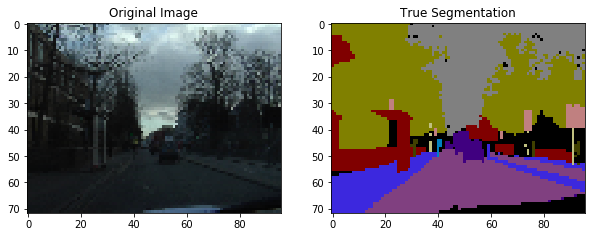

In [10]:
visualize_image_annot(X[0], y[0])

In [11]:
def get_inputs(batch_size):
    inputs = tf.placeholder(tf.float32, [batch_size, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH ])
    labels = tf.placeholder(tf.int64,[batch_size, IMAGE_HEIGHT, IMAGE_WIDTH])
    is_training = tf.placeholder(tf.bool)
    return inputs, labels, is_training

In [12]:
def compute_loss(logits, labels):
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss = tf.reduce_mean(ce)
    tf.summary.scalar('loss', loss)
    return loss

def compute_accuracy(logits, labels):
    correct_prediction = tf.equal(tf.argmax(logits, 3), labels)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)
    return accuracy

def training_op(loss, learning_rate):
    global_step = tf.Variable(0, name='global_step', trainable=False)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.AdamOptimizer(learning_rate=0.1).minimize(loss, global_step=global_step)
    return optimizer, global_step

In [13]:
arg_scope = inference_scope(is_training=True, batch_norm_decay=0.95)
inputs, labels, is_training = get_inputs(batch_size=TRAIN_BATCH_SIZE)
with slim.arg_scope(arg_scope):
    logits, predicted_annotations = inference(inputs, class_inc_bg=NUM_CLASSES)

In [14]:
loss = compute_loss(logits, labels)
optimizer, global_step = training_op(loss, 0.0001)
accuracy = compute_accuracy(logits, labels)

In [ ]:
def build_segnet(inputs, labels, is_training, batch_size,learning_rate, batch_norm_decay=0.95):
    class SegnetModel():
        pass
    segnet_model = SegnetModel()
    arg_scope = inference_scope(is_training=is_training, batch_norm_decay=batch_norm_decay)
    inputs, labels, is_training = get_inputs(batch_size=TRAIN_BATCH_SIZE)
    with slim.arg_scope(arg_scope):
        segnet_model.logits, predicted_annotations = inference(inputs, class_inc_bg=NUM_CLASSES)
    segnet_model.loss = compute_loss(logits, labels)
    segnet_model.optimizer, segnet_model.global_step = training_op(loss, learning_rate)
    segnet_model.accuracy = compute_accuracy(logits, labels)
    return segnet_model

def segnet_model_fn(inputs, labels,mode, params):
    
    segnet_model = build_segnet(inputs, labels,
                                batch_size=params['batch_size'],
                                learning_rate = params['learning_rate'],
                                batch_norm_decay = params['bn_decay'])
    

## Pure DL Approach

In [ ]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(train_iterator.initializer)

for i in range(NUM_ITERS):
    train_image, train_labels =sess.run(train_iterator.get_next())
    if len(train_image) < TRAIN_BATCH_SIZE:
        sess.run(train_iterator.initializer)
        train_image, train_labels =sess.run(train_iterator.get_next())
    _, loss_,accuracy_ = sess.run([optimizer,loss, accuracy], feed_dict={inputs: train_image, labels:train_labels,
                                                  is_training: True})
    
    if i % 100 == 0:
        print(f"Iter: {i},Loss: {loss_}, Acc:{accuracy_}")
        if i > 0:
            sess.run(val_iterator.initializer)
            val_image, val_labels = sess.run(val_iterator.get_next())
            val_acc,preds = sess.run([accuracy,predicted_annotations],
                                     feed_dict={inputs: val_image, labels:val_labels,
                                                         is_training: False})
            print(f"Val Acc:{val_acc}")
            visualize_image_annot(val_image[0],val_labels[0],preds[0])

## Probabilistic Approach

In [15]:
import edward as ed
from edward.models import Categorical, Normal

In [16]:
inputs = tf.placeholder(tf.float32, [TRAIN_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH ])
labels = tf.placeholder(tf.int32,[TRAIN_BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH])
is_training = tf.placeholder(tf.bool)

In [ ]:
def segnet_simple(inputs_):
    conv1_w = Normal(loc=tf.zeros([3,3,3,NUM_CLASSES]), scale=tf.ones([3,3,3,NUM_CLASSES]))
    conv1_b = Normal(loc=tf.zeros([NUM_CLASSES]), scale=tf.ones([NUM_CLASSES]))
    conv1_logit = tf.nn.conv2d(inputs_,conv1_w, strides=[1,1,1,1], padding='SAME')
    conv1_logit = conv1_logit + conv1_b
    predicted_mask = Categorical(logits=conv1_logit)
    conv1_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,3,NUM_CLASSES])), 
                  scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,3,NUM_CLASSES]))))
    conv1_qb = Normal(loc=tf.Variable(tf.random_normal([NUM_CLASSES])),
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([NUM_CLASSES]))))
    latent_dict = {conv1_w: conv1_qw, conv1_b: conv1_qb}
    return predicted_mask, latent_dict

predicted_mask, latent_dict = segnet_simple(inputs)

In [ ]:
def segnet_advanced(inputs_, is_training):
    conv1_w = Normal(loc=tf.zeros([3,3,3,64]), scale=tf.ones([3,3,3,64]))
    conv1_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(inputs,conv1_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training)
    net = tf.nn.relu(net)
    net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    net = unpool_with_argmax(net, arg1, name='maxunpool3')
    conv1r_w = Normal(loc=tf.zeros([3,3,64,NUM_CLASSES]), scale=tf.ones([3,3,64,NUM_CLASSES]))
    conv1r_b = Normal(loc=tf.zeros([NUM_CLASSES]), scale=tf.ones([NUM_CLASSES]))
    net = tf.nn.conv2d(net,conv1r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1r_b
    predicted_mask = Categorical(logits=net)
    conv1_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,3,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,3,64]))))
    conv1_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))

    conv1r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES]))))
    conv1r_qb = Normal(loc=tf.Variable(tf.random_normal([NUM_CLASSES])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([NUM_CLASSES]))))
    latent_dict = {conv1_w: conv1_qw, conv1_b: conv1_qb, conv1r_w:conv1r_qw, conv1r_b: conv1r_qb }
    
    return predicted_mask, latent_dict

predicted_mask, latent_dict = segnet_advanced(inputs, is_training)

In [17]:
def segnet_advanced2(inputs_, is_training):
    conv1_w = Normal(loc=tf.zeros([3,3,3,64]), scale=tf.ones([3,3,3,64]))
    conv1_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(inputs,conv1_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
    conv2_w = Normal(loc=tf.zeros([3,3,64,128]), scale=tf.ones([3,3,64,128]))
    conv2_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv2_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg2 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    conv3_w = Normal(loc=tf.zeros([3,3,128,256]), scale=tf.ones([3,3,128,256]))
    conv3_b = Normal(loc=tf.zeros([256]), scale=tf.ones([256]))
    net = tf.nn.conv2d(net,conv3_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg3 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    net = unpool_with_argmax(net, arg3, name='maxunpool_arg3')
    conv3r_w = Normal(loc=tf.zeros([3,3,256,128]), scale=tf.ones([3,3,256,128]))
    conv3r_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv3r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg2, name='maxunpool_arg2')
    conv2r_w = Normal(loc=tf.zeros([3,3,128,64]), scale=tf.ones([3,3,128,64]))
    conv2r_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(net,conv2r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg1, name='maxunpool_arg1')
    conv1r_w = Normal(loc=tf.zeros([3,3,64,NUM_CLASSES]), scale=tf.ones([3,3,64,NUM_CLASSES]))
    conv1r_b = Normal(loc=tf.zeros([NUM_CLASSES]), scale=tf.ones([NUM_CLASSES]))
    net = tf.nn.conv2d(net,conv1r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1r_b
    #net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    #net = tf.nn.relu(net)
    
    predicted_mask = Categorical(logits=net)
    
    conv3_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,256])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,256]))))
    conv3_qb = Normal(loc=tf.Variable(tf.random_normal([256])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
    
    conv3r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,256,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,256,128]))))
    conv3r_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))
    
    conv2_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,128]))))
    conv2_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))

    conv2r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,64]))))
    conv2r_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))
    
    conv1_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,3,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,3,64]))))
    conv1_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))

    conv1r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES]))))
    conv1r_qb = Normal(loc=tf.Variable(tf.random_normal([NUM_CLASSES])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([NUM_CLASSES]))))
    
    
    latent_dict = {conv1_w: conv1_qw, conv1_b: conv1_qb, 
                   conv1r_w:conv1r_qw, conv1r_b: conv1r_qb,
                   conv2_w: conv2_qw, conv2_b: conv2_qb, 
                   conv2r_w:conv2r_qw, conv2r_b: conv2r_qb,
                   conv3_w: conv3_qw, conv3_b: conv3_qb, 
                   conv3r_w:conv3r_qw, conv3r_b: conv3r_qb
                  }
    
    return predicted_mask, latent_dict

predicted_mask, latent_dict = segnet_advanced2(inputs, is_training)

In [ ]:
def segnet_advanced3(inputs_, is_training):
    conv1_w = Normal(loc=tf.zeros([3,3,3,64]), scale=tf.ones([3,3,3,64]))
    conv1_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    conv11_w = Normal(loc=tf.zeros([3,3,64,64]), scale=tf.ones([3,3,64,64]))
    conv11_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(inputs,conv1_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net = tf.nn.conv2d(net,conv11_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv11_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg1 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    
    conv2_w = Normal(loc=tf.zeros([3,3,64,128]), scale=tf.ones([3,3,64,128]))
    conv2_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    conv21_w = Normal(loc=tf.zeros([3,3,128,128]), scale=tf.ones([3,3,128,128]))
    conv21_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv2_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net = tf.nn.conv2d(net,conv21_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv21_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg2 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    conv3_w = Normal(loc=tf.zeros([3,3,128,256]), scale=tf.ones([3,3,128,256]))
    conv3_b = Normal(loc=tf.zeros([256]), scale=tf.ones([256]))
    net = tf.nn.conv2d(net,conv3_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    net, arg3 = tf.nn.max_pool_with_argmax(net, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    net = unpool_with_argmax(net, arg3, name='maxunpool_arg3')
    conv3r_w = Normal(loc=tf.zeros([3,3,256,128]), scale=tf.ones([3,3,256,128]))
    conv3r_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv3r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv3r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg2, name='maxunpool_arg2')
    conv21r_w = Normal(loc=tf.zeros([3,3,128,128]), scale=tf.ones([3,3,128,128]))
    conv21r_b = Normal(loc=tf.zeros([128]), scale=tf.ones([128]))
    net = tf.nn.conv2d(net,conv21r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv21r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    conv2r_w = Normal(loc=tf.zeros([3,3,128,64]), scale=tf.ones([3,3,128,64]))
    conv2r_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(net,conv2r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv2r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    
    net = unpool_with_argmax(net, arg1, name='maxunpool_arg1')
    conv11r_w = Normal(loc=tf.zeros([3,3,64,64]), scale=tf.ones([3,3,64,64]))
    conv11r_b = Normal(loc=tf.zeros([64]), scale=tf.ones([64]))
    net = tf.nn.conv2d(net,conv11r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv11r_b
    net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    net = tf.nn.relu(net)
    conv1r_w = Normal(loc=tf.zeros([3,3,64,NUM_CLASSES]), scale=tf.ones([3,3,64,NUM_CLASSES]))
    conv1r_b = Normal(loc=tf.zeros([NUM_CLASSES]), scale=tf.ones([NUM_CLASSES]))
    net = tf.nn.conv2d(net,conv1r_w, strides=[1,1,1,1], padding='SAME')
    net = net + conv1r_b
    #net = tf.contrib.layers.batch_norm(net, is_training=is_training, decay=0.99)
    #net = tf.nn.relu(net)
    
    predicted_mask = Categorical(logits=net)
    
    conv3_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,256])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,256]))))
    conv3_qb = Normal(loc=tf.Variable(tf.random_normal([256])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([256]))))
    
    conv3r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,256,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,256,128]))))
    conv3r_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))
    
    conv2_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,128]))))
    conv2_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))
    conv21_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,128]))))
    conv21_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))

    conv21r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,128])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,128]))))
    conv21r_qb = Normal(loc=tf.Variable(tf.random_normal([128])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([128]))))
    
    conv2r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,128,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,128,64]))))
    conv2r_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))
    
    conv1_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,3,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,3,64]))))
    conv1_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))
    
    conv11_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,64]))))
    conv11_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))
    
    conv11r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,64])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,64]))))
    conv11r_qb = Normal(loc=tf.Variable(tf.random_normal([64])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([64]))))

    conv1r_qw = Normal(loc=tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES])), 
                      scale=tf.nn.softplus(tf.Variable(tf.random_normal([3,3,64,NUM_CLASSES]))))
    conv1r_qb = Normal(loc=tf.Variable(tf.random_normal([NUM_CLASSES])),
                          scale=tf.nn.softplus(tf.Variable(tf.random_normal([NUM_CLASSES]))))
    
    
    latent_dict = {conv1_w: conv1_qw, conv1_b: conv1_qb, 
                   conv11_w: conv11_qw, conv11_b: conv11_qb, 
                   conv1r_w:conv1r_qw, conv1r_b: conv1r_qb,
                   conv11r_w:conv11r_qw, conv11r_b: conv11r_qb,
                   conv2_w: conv2_qw, conv2_b: conv2_qb, 
                   conv21_w: conv21_qw, conv21_b: conv21_qb,
                   conv21r_w:conv21r_qw, conv21r_b: conv21r_qb,
                   conv2r_w:conv2r_qw, conv2r_b: conv2r_qb,
                   conv3_w: conv3_qw, conv3_b: conv3_qb, 
                   conv3r_w:conv3r_qw, conv3r_b: conv3r_qb
                  }
    
    return predicted_mask, latent_dict

predicted_mask, latent_dict = segnet_advanced3(inputs, is_training)

In [18]:
latent_dict

{<ed.RandomVariable 'Normal_2/' shape=(3, 3, 3, 64) dtype=float32>: <ed.RandomVariable 'Normal_62/' shape=(3, 3, 3, 64) dtype=float32>,
 <ed.RandomVariable 'Normal_5/' shape=(64,) dtype=float32>: <ed.RandomVariable 'Normal_65/' shape=(64,) dtype=float32>,
 <ed.RandomVariable 'Normal_32/' shape=(3, 3, 64, 12) dtype=float32>: <ed.RandomVariable 'Normal_68/' shape=(3, 3, 64, 12) dtype=float32>,
 <ed.RandomVariable 'Normal_35/' shape=(12,) dtype=float32>: <ed.RandomVariable 'Normal_71/' shape=(12,) dtype=float32>,
 <ed.RandomVariable 'Normal_8/' shape=(3, 3, 64, 128) dtype=float32>: <ed.RandomVariable 'Normal_50/' shape=(3, 3, 64, 128) dtype=float32>,
 <ed.RandomVariable 'Normal_11/' shape=(128,) dtype=float32>: <ed.RandomVariable 'Normal_53/' shape=(128,) dtype=float32>,
 <ed.RandomVariable 'Normal_26/' shape=(3, 3, 128, 64) dtype=float32>: <ed.RandomVariable 'Normal_56/' shape=(3, 3, 128, 64) dtype=float32>,
 <ed.RandomVariable 'Normal_29/' shape=(64,) dtype=float32>: <ed.RandomVariable 

In [ ]:
inference = ed.KLqp(latent_dict, data={predicted_mask: labels})

In [ ]:
N = NUM_TRAIN
M = TRAIN_BATCH_SIZE
n_batch=int(N/M)
n_epoch = 150
loss = []
inference.initialize(n_iter=n_batch*n_epoch, n_samples=5, scale={predicted_mask: N/M})
saver = tf.train.Saver()
sess = ed.get_session()
sess.run(tf.global_variables_initializer())
sess.run(train_iterator.initializer)
for i in range(inference.n_iter):
    train_image, train_labels =sess.run(train_iterator.get_next())
    if len(train_image) < TRAIN_BATCH_SIZE:
        sess.run(train_iterator.initializer)
        train_image, train_labels =sess.run(train_iterator.get_next())
    info_dict = inference.update({inputs: train_image, labels: train_labels, is_training: True})
    inference.print_progress(info_dict)
    loss.append(info_dict['loss'])
    if info_dict['loss'] < 0.8e+6:
        print(i)
        break
saver.save(sess, "tmp/test_saver")

In [19]:
sess = ed.get_session()
saver = tf.train.Saver()
saver.restore(sess, "tmp/test_saver")

INFO:tensorflow:Restoring parameters from tmp/test_saver


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [3,3,3,64] rhs shape= [3,3,128,128]
	 [[Node: save/Assign_23 = Assign[T=DT_FLOAT, _class=["loc:@Variable_16"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_16, save/RestoreV2_23/_15)]]

Caused by op 'save/Assign_23', defined at:
  File "/home/aravind/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/aravind/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-ad8ec01d825a>", line 2, in <module>
    saver = tf.train.Saver()
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1140, in __init__
    self.build()
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1172, in build
    filename=self._filename)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 688, in build
    restore_sequentially, reshape)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/state_ops.py", line 274, in assign
    validate_shape=validate_shape)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_state_ops.py", line 43, in assign
    use_locking=use_locking, name=name)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/aravind/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [3,3,3,64] rhs shape= [3,3,128,128]
	 [[Node: save/Assign_23 = Assign[T=DT_FLOAT, _class=["loc:@Variable_16"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/gpu:0"](Variable_16, save/RestoreV2_23/_15)]]


In [ ]:
sess.run(val_iterator.initializer)
val_image, val_labels =sess.run(val_iterator.get_next())

In [ ]:
loss = np.array(loss)

In [ ]:
plt.plot(loss[10:])

In [ ]:
def bayes_visualize_image_annot(img_data, annot_data, predicted_annot, ax, n_samples=20):
    ax[0].imshow(img_data)
    ax[0].set_title('Original Image')
    ax[1].imshow(img_annot_to_rgb(predicted_annot), alpha=0.1)
    ax[1].set_title('Posterior Predicted Segmentation %d samples' % n_samples)
    ax[2].imshow(img_annot_to_rgb(annot_data))
    ax[2].set_title('True Segmentation')
    #plt.show()

In [ ]:
ppc_nsamples=100
predicted_mask_post = ed.copy(predicted_mask, latent_dict)
predicted_mask_post_samples = predicted_mask_post.sample(ppc_nsamples)
ppc=sess.run(predicted_mask_post_samples,
             feed_dict={inputs: val_image, predicted_mask: val_labels, is_training: True})

In [ ]:
idx=31
fig, ax = plt.subplots(1,3,figsize=(10,12))
for j in range(20):
    bayes_visualize_image_annot(val_image[idx], val_labels[idx],ppc[j,idx],ax, n_samples=ppc_nsamples)

In [ ]:
val_image.shape